# Задание 1
## Написать теггер на данных с русcким языком

In [1]:
# !pip install pyconll
# !mkdir datasets
# !wget -O ./datasets/ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
# !wget -O ./datasets/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import pyconll

from gensim.models import Word2Vec, FastText

from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger, SequentialBackoffTagger
from nltk.corpus import names
import nltk
nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [3]:
# loading data
full_train = pyconll.load_from_file('datasets/ru_syntagrus-ud-train.conllu')
full_test = pyconll.load_from_file('datasets/ru_syntagrus-ud-dev.conllu')

In [4]:
def convert_data(dataset):
    result = []

    for sent in dataset:
        for token in sent:
            result.append((token.form.lower(), token.upos))
            
    return result

In [5]:
train_data = convert_data(full_train) 
train_data[:5]

[('анкета', 'NOUN'),
 ('.', 'PUNCT'),
 ('начальник', 'NOUN'),
 ('областного', 'ADJ'),
 ('управления', 'NOUN')]

In [6]:
test_data = convert_data(full_test) 
test_data[:5]

[('алгоритм', 'NOUN'),
 (',', 'PUNCT'),
 ('от', 'ADP'),
 ('имени', 'NOUN'),
 ('учёного', 'NOUN')]

### 1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбинации 

In [7]:
def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

,UnigramTagger,BigramTagger,TrigramTagger,CombineTagger
values,,,,
1000,0.399951,0.00174401,0.00171873,0.401164
2000,0.449963,0.00174401,0.00171873,0.451429
4000,0.489064,0.00174401,0.00171873,0.491111
8000,0.525351,0.00722879,0.00171873,0.527390
16000,0.585718,0.0879503,0.00171873,0.588237


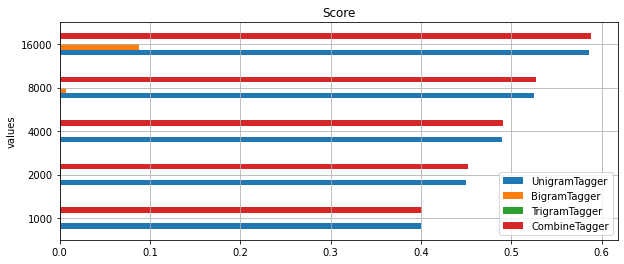

In [8]:
df_score = pd.DataFrame(columns=['values', 'UnigramTagger', 'BigramTagger', 'TrigramTagger']).set_index('values')
COUNT = (1000, 2000, 4000, 8000, 16000)

for C in COUNT:
    
    unigram_tagger = UnigramTagger([train_data[:C]])
    bigram_tagger = BigramTagger([train_data[:C]])
    trigram_tagger = TrigramTagger([train_data[:C]])
    combine_tagger = backoff_tagger([train_data[:C]], [UnigramTagger, BigramTagger, TrigramTagger])

    df_score.loc[C, 'UnigramTagger'] = unigram_tagger.evaluate([test_data])
    df_score.loc[C, 'BigramTagger'] = bigram_tagger.evaluate([test_data])
    df_score.loc[C, 'TrigramTagger'] = trigram_tagger.evaluate([test_data])
    df_score.loc[C, 'CombineTagger'] = combine_tagger.evaluate([test_data])
    
df_score.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
df_score

#### Вывод:
- Скорость сильно падает при увеличении количества объектов для обучения
- Для хорошей точности необходимо большое число объектов > 80000
- В соло триграмм и биграмм теггеры сильно проигрывают в точности униграмму
- Комбинация не всегда показывает лучший результат
- До числа объектов < 8000, скор биграмма не растет
- При приведении к нижнему регистру всех обучающих данных скор немного поднялся

### 2. написать свой теггер как на занятии, но улучшить попробовать разные векторайзеры, добавить знание не только букв и слов но и совместно объединить эти признаки  

In [9]:
def split_tok_lbl(data):
  toks = []
  lbls = []

  for tok, lbl in data:
    toks.append(tok)
    lbls.append('NO_TAG' if lbl is None else lbl)

  return toks, lbls

In [10]:
train_tok, train_lbls = split_tok_lbl(train_data)
train_tok[:5], train_lbls[:5]

(['анкета', '.', 'начальник', 'областного', 'управления'],
 ['NOUN', 'PUNCT', 'NOUN', 'ADJ', 'NOUN'])

In [11]:
test_tok, test_lbls = split_tok_lbl(test_data)
test_tok[:5], test_lbls[:5]

(['алгоритм', ',', 'от', 'имени', 'учёного'],
 ['NOUN', 'PUNCT', 'ADP', 'NOUN', 'NOUN'])

['ADJ' 'ADP' 'ADV' 'AUX' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NO_TAG' 'NUM' 'PART'
 'PRON' 'PROPN' 'PUNCT' 'SCONJ' 'SYM' 'VERB' 'X']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,CastomTagger
vectorizer,
hv_char,0.644054
cv_char,0.757625
hv_word,0.231187
cv_word,0.360193
hv_ch_w,0.703426
cv_ch_w,0.760641


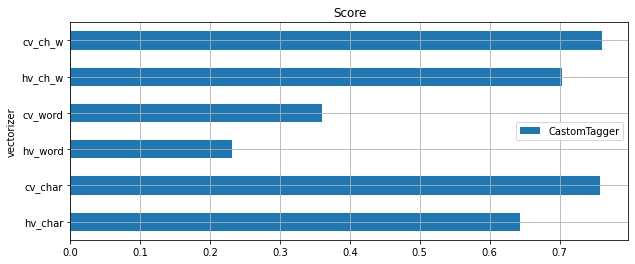

In [12]:
COUNT = 16000

df_score_vec = pd.DataFrame(columns=['vectorizer', 'CastomTagger']).set_index('vectorizer')

le = LabelEncoder()
y_train = le.fit_transform(train_lbls)
y_test = le.transform(test_lbls)
print(le.classes_)

for key_vec, val_vec in {'hv_char': HashingVectorizer(ngram_range=(1,5), analyzer='char', n_features=100),
                         'cv_char': CountVectorizer(ngram_range=(1,5), analyzer='char', max_features=100),
                         'hv_word': HashingVectorizer(ngram_range=(1,5), analyzer='word', n_features=100),
                         'cv_word': CountVectorizer(ngram_range=(1,5), analyzer='word', max_features=100),
                         'hv_ch_w': HashingVectorizer(ngram_range=(1,5), analyzer='char_wb', n_features=100),
                         'cv_ch_w': CountVectorizer(ngram_range=(1,5), analyzer='char_wb', max_features=100)}.items():

    X_train = val_vec.fit_transform(train_tok[:COUNT])
    X_test = val_vec.transform(test_tok)

    lr = LogisticRegression()
    lr.fit(X_train, y_train[:COUNT])
    y_pred = lr.predict(X_test)

    df_score_vec.loc[key_vec, 'CastomTagger'] = accuracy_score(y_test, y_pred)

df_score_vec.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
df_score_vec

### Вывод:
- Лучше всего себя показали комбинации букв и слов
- Чисто на словах скор сильно упал

### 3. вместо векторайзеров взять эмбединги попробовать (word2vec и fasttext по желанию дополнительно можно взять tf.keras.layers.Embedding)

### 4. взять не только эмбединги каждого слова, но и взять соседей, т.е. информацию о соседях количество соседей выбрать самим (узнать наилучшее количество соседей)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call t

,CastomTagger
vectorizer,
hv_char,0.644054
cv_char,0.757625
hv_word,0.231187
cv_word,0.360193
hv_ch_w,0.703426
cv_ch_w,0.760641
W2V 3,0.411123
FT 3,0.387853
W2V 5,0.417467


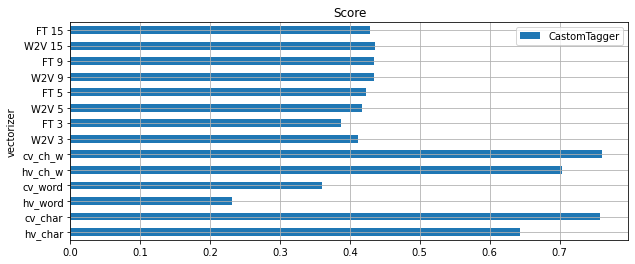

In [13]:
for window in (3, 5, 9, 15):
  for emb_key, emd_val in {'W2V': Word2Vec(sentences=[train_tok[:COUNT] + test_tok], size=300, window=window, min_count=1), 
                           'FT': FastText(sentences=[train_tok[:COUNT] + test_tok], size=300, window=window, min_count=1)}.items():

    X_train = np.array([emd_val[word] for word in train_tok[:COUNT]])
    X_test = np.array([emd_val[word] for word in test_tok])

    lr = LogisticRegression()
    lr.fit(X_train, y_train[:COUNT])
    y_pred = lr.predict(X_test)

    df_score_vec.loc[f'{emb_key} {window}', 'CastomTagger'] = accuracy_score(y_test, y_pred)

df_score_vec.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
df_score_vec

### 5. сравнить все реализованные методы сделать выводы

#### Вывод:
- Эмбединги показали себя хуже, чем векторайзеры
- Лучший эмбеддин - W2V с 15 сосебяди